In [1]:
import logging

import graphcat.notebook

logging.basicConfig(level=logging.DEBUG)

In [2]:
def on_execute(sender, name, inputs):
    logging.debug(f"Executing '{name}'. Inputs: {inputs}")

In [3]:
class LoopBlock(object):
    def __init__(self, graph, iteration="loop-iteration", begin="loop-begin", end="loop-end", gather="loop-gather"):
        self._graph = graph
        self._iteration = iteration
        self._begin = begin
        self._end = end
        self._gather = gather
        
        graph.set_task(iteration, graphcat.null)
        graph.set_task(begin, self.loop_begin)
        graph.set_task(end, self.loop_end)
        graph.set_task(gather, self.loop_gather)

        graph.set_links(end, (gather, 0))
        
        self._iterating = False
        self._loop_output = []

    def loop_begin(self, graph, name, inputs):
        if not self._iterating:
            self._iterating = True
            self._loop_output = []
            for i in range(3):
                logging.debug(f"Loop iteration {i}")
                self._graph.set_task(self._iteration, graphcat.constant(i))
                self._graph.mark_unfinished(name)
                self._loop_output.append(self._graph.output(self._end))
            self._iterating = False
        return inputs.get(0, [None])[0]
        
    def loop_end(self, graph, name, inputs):
        return inputs.get(0, [None])[0]
        
    def loop_gather(self, graph, name, inputs):
        return self._loop_output


In [4]:
graph = graphcat.StaticGraph()
logger = graphcat.Logger(graph)
graph.on_execute.connect(on_execute);

DEBUG:graphcat.common:Task A updating.
DEBUG:root:Executing 'A'. Inputs: {}
INFO:graphcat.common:Task A executing. Inputs: {}
INFO:graphcat.common:Task A finished. Output: foo
DEBUG:graphcat.common:Task loop-begin updating.
DEBUG:root:Executing 'loop-begin'. Inputs: {0: foo}
INFO:graphcat.common:Task loop-begin executing. Inputs: {0: foo}
DEBUG:root:Loop iteration 0
DEBUG:graphcat.common:Task A updating.
DEBUG:graphcat.common:Task loop-begin updating.
DEBUG:root:Executing 'loop-begin'. Inputs: {0: foo}
INFO:graphcat.common:Task loop-begin executing. Inputs: {0: foo}
INFO:graphcat.common:Task loop-begin finished. Output: f
DEBUG:graphcat.common:Task B updating.
DEBUG:root:Executing 'B'. Inputs: {None: f}
INFO:graphcat.common:Task B executing. Inputs: {None: f}
INFO:graphcat.common:Task B finished. Output: bar
DEBUG:graphcat.common:Task loop-end updating.
DEBUG:root:Executing 'loop-end'. Inputs: {0: bar}
INFO:graphcat.common:Task loop-end executing. Inputs: {0: bar}
INFO:graphcat.common:

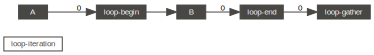

DEBUG:graphcat.common:Task A updating.
DEBUG:graphcat.common:Task loop-begin updating.
DEBUG:graphcat.common:Task B updating.
DEBUG:graphcat.common:Task loop-end updating.
DEBUG:graphcat.common:Task loop-gather updating.


['b', 'b', 'b']

In [5]:
loop = LoopBlock(graph)

graph.add_task("A", graphcat.constant("foo"))
graph.set_links("A", ("loop-begin", 0))

graph.add_task("B", graphcat.constant("bar"))
graph.set_links("loop-begin", "B")
graph.set_links("B", ("loop-end", 0))

graph.update("loop-gather")
graphcat.notebook.display(graph)
graph.output("loop-gather")